In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.misc as misc
%matplotlib inline

In [2]:
## data importing

X_train=pd.read_csv('train.csv',delimiter=" ",header=None).as_matrix()
y_train = pd.read_csv('trainLabel.csv', delimiter=' ', header=None).as_matrix()

X_test =pd.read_csv('test.csv',delimiter=" ",header=None).as_matrix()
y_test =pd.read_csv('testLabel.csv', delimiter=' ', header=None).as_matrix()

In [3]:
#plt.imshow(X_train[39805].reshape(35,35),cmap=plt.cm.gray)

In [4]:
sizeInput = X_train.shape[1]  # input vector size
OutputVector = 24 # 24개 label

# one hot encoding
sam = np.eye(OutputVector)

train_label=sam[y_train.flatten()-1]
test_label =sam[y_test.flatten()-1]

In [5]:
### CNN 모델링

class Model:
    
    def __init__(self,sess,name):
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self):
        
        with tf.variable_scope(self.name):
            
            self.learning_rate=0.7 # 일단 0.5는 잘 된다
            self.training = tf.placeholder(tf.bool)
            
            ### placeholder
            self.X = tf.placeholder(tf.float32,[None,sizeInput])
            self.Y = tf.placeholder(tf.float32,[None,OutputVector])
            # 이미지 형식으로 형태 변환
            self.X_img = tf.reshape(self.X,[-1,35,35,1]) 
            
            ## conv layer 1 -> 5*5*32 filter
            ## relu activation 함수 사용하고, kernel size는 5*5 , ouput filter 개수가 32개, stride는 1칸씩
            ## max pooling 2*2 -> 18*18로 줄여짐
            ## dropout with ratio 0.7
            
            with tf.variable_scope('layer1'):
                conv1 = tf.layers.conv2d(self.X_img,filters=32,kernel_size=5,strides=1,
                                         padding="SAME",activation=tf.nn.relu) 
        
                pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding="SAME")
            
                dropout1 = tf.layers.dropout(pool1,rate=0.7,training=self.training)
                
            ## conv layer 2 -> 3*3*64 filters
            ## relu activation 함수 사용하고, kernel size는 3*3 , ouput filter 개수가 64개, stride는 1칸씩
            ## max pooling 2*2 -> 9*9로 줄여짐
            ## dropout with ratio 0.7
                
            with tf.variable_scope('layer2'):
                conv2 = tf.layers.conv2d(dropout1,filters=64,kernel_size=3,strides=1,
                                        padding="SAME",activation=tf.nn.relu)

                pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding="SAME")
                dropout2 = tf.layers.dropout(pool2,rate=0.7,training=self.training)
                
            ## conv layer 3 -> 3*3*128 filters
            ## relu activation 함수 사용하고, kernel size는 3*3 , ouput filter 개수가 128개, stride는 1칸씩
            ## max pooling 2*2 -> 5*5로 줄여짐
            ## dropout with ratio 0.7

            with tf.variable_scope('layer3'):
                conv3 = tf.layers.conv2d(dropout2,filters=128,kernel_size=3,strides=1,
                                        padding="SAME",activation=tf.nn.relu)
                pool3 = tf.layers.max_pooling2d(conv3,pool_size=2,strides=2,padding="SAME")
                dropout3 = tf.layers.dropout(pool3,rate=0.7,training=self.training)
                  
            s1 = int(dropout3.shape[1])
                
            ###### fully connected layer 마지막으로 만들어줌
            ## 5*5*128 -> output 1024개 
            ## relu activation 사용함
            
            with tf.variable_scope('layer4'):
                flat = tf.reshape(dropout3,[-1,s1*s1*128])
                f4 = tf.layers.dense(flat,units=1024,activation=tf.nn.relu)
                dropout4 = tf.layers.dropout(f4,rate=0.5,training=self.training)
                
            with tf.variable_scope('output'):
                self.logits = tf.layers.dense(dropout4,units=OutputVector)
                
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,labels=self.Y))
        self.optimizer = tf.train.AdadeltaOptimizer(self.learning_rate).minimize(self.cost)
        
        correct_prediction=tf.equal(tf.argmax(self.logits,1),tf.argmax(self.Y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
        
        # 예측값 출력하는 함수
    def predict(self,X_test,training=False):
        return self.sess.run(self.logits,
                            feed_dict={self.X:X_test,self.training:training})
        # 정확도 측정
    def get_accuracy(self,X_test,Y_test,training=False):
        return self.sess.run(self.accuracy,
                            feed_dict={self.X:X_test,self.Y:Y_test,self.training:training})
        # 학습 함수
    def train(self,x_data,y_data,training=True):
        return self.sess.run([self.cost,self.optimizer],
                            feed_dict={self.X:x_data,self.Y:y_data,self.training:training})

In [6]:
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

models = Model(sess,name='m1')

sess.run(tf.global_variables_initializer())


### hyper parameter


batch_size = 200
train_epoch = 50

num_batch = int(len(X_train)/batch_size)

training_acc_cnn=[]
test_acc_cnn=[]

print("Start Training")

for epoch in range(train_epoch):
    
    p1 = np.random.permutation(len(X_train))
    x_data = X_train[p1]
    y_data = train_label[p1]
    
    p2 = np.random.permutation(len(X_test))
    x_test = X_test[p2]
    y_test = test_label[p2]
    
    avg_cost=0.
    
    for i in range(0,num_batch):
        batch_xs,batch_ys = x_data[i*batch_size:((i+1)*batch_size)],y_data[i*batch_size:((i+1)*batch_size)]
        
        c,_ = models.train(batch_xs,batch_ys)
        avg_cost += c/(num_batch)
        
    print('Epoch:', '%04d' % (epoch+1),'cost = ',avg_cost)
    
    training_acc_cnn.append(models.get_accuracy(x_data,y_data))
    test_acc_cnn.append(models.get_accuracy(x_test,y_test))
    
print('Learning Finished')
    
sess.close()

Start Training
Epoch: 0001 cost =  2.53455851066
Epoch: 0002 cost =  1.52044289615
Epoch: 0003 cost =  1.09132176458
Epoch: 0004 cost =  0.887891033187
Epoch: 0005 cost =  0.767162729747
Epoch: 0006 cost =  0.689889017961
Epoch: 0007 cost =  0.633653127219
Epoch: 0008 cost =  0.59047779381
Epoch: 0009 cost =  0.56442138328
Epoch: 0010 cost =  0.533582862897
Epoch: 0011 cost =  0.5125638579
Epoch: 0012 cost =  0.497428015698
Epoch: 0013 cost =  0.48114959993
Epoch: 0014 cost =  0.464181344264
Epoch: 0015 cost =  0.453483451401
Epoch: 0016 cost =  0.445172210884
Epoch: 0017 cost =  0.436895369585
Epoch: 0018 cost =  0.42759700142
Epoch: 0019 cost =  0.420647388577
Epoch: 0020 cost =  0.417352260657
Epoch: 0021 cost =  0.410513260257
Epoch: 0022 cost =  0.402869646124
Epoch: 0023 cost =  0.394283088008
Epoch: 0024 cost =  0.3925855323
Epoch: 0025 cost =  0.38829878332
Epoch: 0026 cost =  0.380874235277
Epoch: 0027 cost =  0.375772222352
Epoch: 0028 cost =  0.37559855164
Epoch: 0029 cost =

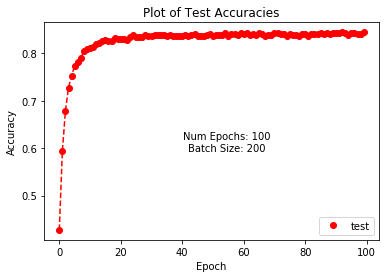

In [7]:
plt.plot(test_acc,'ro',label="test")
plt.plot(test_acc,'r--')
plt.ylabel('Accuracy')  # Accuracy label
plt.xlabel('Epoch')
plt.title('Plot of Test Accuracies')
plt.legend()
ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
midXLoc = (xmax - xmin)/2
topYLoc = ymax - (ymax-ymin)*0.5
plt.text(midXLoc, topYLoc, 'Num Epochs: ' + str(train_epoch) + '\nBatch Size: ' + str(batch_size), ha='center', va='top')

## linear regression

In [8]:
X = tf.placeholder(tf.float32,[None,sizeInput])
Y = tf.placeholder(tf.float32,[None,OutputVector])

W = tf.Variable(tf.random_normal([sizeInput,OutputVector],mean=0,stddev=0.1))
b = tf.Variable(tf.zeros([OutputVector]))

y_hat = tf.matmul(X,W) + b

learning_rate = 0.5

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_hat,labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y_hat,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))


batch_size = 200
train_epoch = 50

num_batch = int(len(X_train)/batch_size)

training_acc_reg=[]
test_acc_reg=[]

print("Start Training")

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())

for epoch in range(train_epoch):
    
    p1 = np.random.permutation(len(X_train))
    x_data = X_train[p1]
    y_data = train_label[p1]
    
    p2 = np.random.permutation(len(X_test))
    x_test = X_test[p2]
    y_test = test_label[p2]
    
    avg_cost=0.
    
    for i in range(0,num_batch):
        batch_xs,batch_ys = x_data[i*batch_size:((i+1)*batch_size)],y_data[i*batch_size:((i+1)*batch_size)]
        
        c,_ = sess.run([cost,optimizer],feed_dict={X:batch_xs,Y:batch_ys})
        avg_cost += c/(num_batch)
        
    print('Epoch:', '%04d' % (epoch+1),'cost = ',avg_cost)
    
    training_acc_reg.append(sess.run(accuracy,feed_dict={X:x_data,Y:y_data}))
    test_acc_reg.append(sess.run(accuracy,feed_dict={X:x_test,Y:y_test}))
    
print('Learning Finished')

Start Training
Epoch: 0001 cost =  12.5368963594
Epoch: 0002 cost =  11.1066749324
Epoch: 0003 cost =  10.8122718059
Epoch: 0004 cost =  10.600079443
Epoch: 0005 cost =  10.4796810941
Epoch: 0006 cost =  10.2084355378
Epoch: 0007 cost =  10.43396956
Epoch: 0008 cost =  10.3354896325
Epoch: 0009 cost =  10.3140766369
Epoch: 0010 cost =  10.2536481038
Epoch: 0011 cost =  9.685875042
Epoch: 0012 cost =  10.2594061473
Epoch: 0013 cost =  9.86556856836
Epoch: 0014 cost =  10.1289943331
Epoch: 0015 cost =  9.88515750847
Epoch: 0016 cost =  9.96971853774
Epoch: 0017 cost =  10.1063984722
Epoch: 0018 cost =  9.97894370256
Epoch: 0019 cost =  10.1460589021
Epoch: 0020 cost =  9.94465200865
Epoch: 0021 cost =  9.61697251593
Epoch: 0022 cost =  9.72528738472
Epoch: 0023 cost =  9.70471678547
Epoch: 0024 cost =  9.71062437613
Epoch: 0025 cost =  9.76245982443
Epoch: 0026 cost =  9.95797057847
Epoch: 0027 cost =  9.73687418262
Epoch: 0028 cost =  9.75715004619
Epoch: 0029 cost =  9.61372840584
Epoc

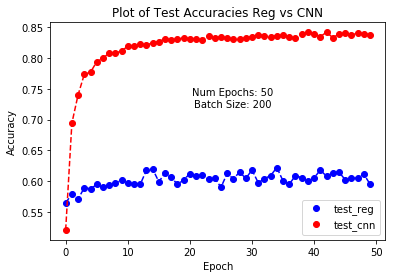

In [11]:
plt.plot(test_acc_reg,'bo',label="test_reg")
plt.plot(test_acc_reg,'b--')
plt.plot(test_acc_cnn,'ro',label="test_cnn")
plt.plot(test_acc_cnn,'r--')
plt.ylabel('Accuracy')  # Accuracy label
plt.xlabel('Epoch')
plt.title('Plot of Test Accuracies Reg vs CNN')
plt.legend()
ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
midXLoc = (xmax - xmin)/2
topYLoc = ymax - (ymax-ymin)*0.3
plt.text(midXLoc, topYLoc, 'Num Epochs: ' + str(train_epoch) + '\nBatch Size: ' + str(batch_size), ha='center', va='top')

In [ ]:
plt.savefig('Code1_test_error', dpi=300)

In [ ]:
np.max(test_acc_cnn)